In [392]:
import requests
import json
import rdflib
from rdflib.extras.external_graph_libs import rdflib_to_networkx_multidigraph
import networkx as nx
import matplotlib.pyplot as plt

from rdflib import URIRef, BNode, Literal, Namespace, Graph
from rdflib.namespace import Namespace, NamespaceManager
from rdflib.plugins import sparql
from rdflib.namespace import RDF, RDFS, XSD
from rdflib.serializer import Serializer

In [393]:
from re import sub
def snake_case(s):
  return '_'.join(
    sub('([A-Z][a-z]+)', r' \1',
    sub('([A-Z]+)', r' \1',
    s.replace('-', ' '))).split()).lower().replace(":", "_").replace("#", "_")

In [394]:
url = 'ontology/animeowl.owl'
g = rdflib.Graph()
result = g.parse(url, format='turtle')

In [395]:
def make_object_property(name, domain, range):
    object_property = URIRef(f"{default_schema}#{name}")
    g.add((object_property, RDF.type, URIRef(f"op_{owl_schema}#ObjectProperty")))
    g.add((object_property, URIRef(f"{rdfs_schema}#domain"), domain))
    g.add((object_property, URIRef(f"{rdfs_schema}#range"), range))
    return object_property

In [396]:
def make_data_property(name, domain):
    data_property = URIRef(f"dp_{default_schema}#{name}")
    g.add((data_property, RDF.type, URIRef(f"{owl_schema}#DatatypeProperty")))
    g.add((data_property, URIRef(f"{rdfs_schema}#domain"), domain))
    return data_property

In [397]:
def link(a, a_rel_type_b, b_rel_type_a, b, is_symmetrical=True):
    g.add((a, a_rel_type_b, b))
    if is_symmetrical:
        g.add((b, b_rel_type_a, a))

In [398]:
#schemas
default_schema = "http://ani.me"
rdfs_schema = "http://www.w3.org/2000/01/rdf-schema"
owl_schema = "http://www.w3.org/2002/07/owl"

# classes
anime_class = URIRef(f"{default_schema}#Anime")
character_class = URIRef(f"{default_schema}#Character")
genre_class = URIRef(f"{default_schema}#Genre")
studio_class = URIRef(f"{default_schema}#Studio")

#object properties
anime_has_character = make_object_property("anime_has_character", anime_class, character_class)
anime_has_genre = make_object_property("anime_has_genre", anime_class, genre_class)
anime_has_studio = make_object_property("anime_has_studio", anime_class, studio_class)
character_has_anime = make_object_property("character_has_anime", character_class, anime_class)
genre_has_anime = make_object_property("genre_has_anime", genre_class, anime_class)
studio_has_anime = make_object_property("studio_has_anime", studio_class, anime_class)


In [399]:
def make_genre_field(individual, field, value, lang=""):
    data_property = make_data_property(snake_case(field), genre_class)
    g.add((individual, data_property, Literal(value, lang=lang)))

def make_genre_individual(genre_model):
    genre_name = snake_case(genre_model["name"])
    individual = URIRef(f"{default_schema}#genre_{genre_name}")
    g.add((individual, RDF.type, URIRef(f"{owl_schema}#NamedIndividual")))
    g.add((individual, RDF.type, genre_class))
    make_genre_field(individual, "name", genre_model["name"])
    make_genre_field(individual, "name", genre_model["russian"], lang="ru")
    make_genre_field(individual, "shiki_id", genre_model["id"])
    make_genre_field(individual, "kind", genre_model["kind"])
    print(individual)
    return individual

In [400]:
def make_studio_field(individual, field, value, lang=""):
    data_property = make_data_property(snake_case(field), studio_class)
    g.add((individual, data_property, Literal(value, lang=lang)))

def make_studio_individual(studio_model):
    studio_name = snake_case(studio_model["name"])
    individual = URIRef(f"{default_schema}#studio_{studio_name}")
    g.add((individual, RDF.type, URIRef(f"{owl_schema}#NamedIndividual")))
    g.add((individual, RDF.type, studio_class))
    make_studio_field(individual, "name", studio_model["name"])
    make_studio_field(individual, "filtered_name", studio_model["filtered_name"])
    make_studio_field(individual, "shiki_id", studio_model["id"])
    make_studio_field(individual, "real", studio_model["real"])
    make_studio_field(individual, "image", studio_model["image"])
    print(individual)
    return individual

In [401]:
def make_character_field(individual, field, value, lang=""):
    data_property = make_data_property(snake_case(field), character_class)
    g.add((individual, data_property, Literal(value, lang=lang)))

def relate(character, type, relation):
    linked_character = make_character_individual({"id":relation["id"], "entity": relation["entity"]})
    relation_type = make_object_property(snake_case(f"relation_{type}"), character_class, character_class)
    relation_knows = make_object_property(snake_case(f"relation_knows"), character_class, character_class)
    link(character, relation_knows, relation_knows, linked_character)
    link(character, relation_type, relation_type, linked_character, is_symmetrical=False)

def make_character_individual(character_model):

    ignore_fields = [
        "info",
        "Anime",
        "Relations",
        "Сharacteristics"
    ]

    character_id = character_model["id"]
    individual = URIRef(f"{default_schema}#character_anidbch{character_id}")
    g.add((individual, RDF.type, URIRef(f"{owl_schema}#NamedIndividual")))
    g.add((individual, RDF.type, character_class))

    for field, value in character_model.items():
        if field not in ignore_fields:
            make_character_field(individual, field, value)
        if field == "info":
            for field, anime in value["Anime"].items():
                linked_anime = make_anime_individual({"name":field})
                link(individual, character_has_anime, anime_has_character, linked_anime)
            for type, relations in value["Relations"].items():
                for relation in relations:
                    relate(individual, type, relation)
            for field, characteristic in value["Сharacteristics"].items():
                if isinstance(field, list):
                    for item in value:
                        make_character_field(individual, field, item)
                else:
                    make_character_field(individual, field, characteristic)
    return individual

In [402]:
def make_anime_field(individual, field, value, lang=""):
    data_property = make_data_property(snake_case(field), anime_class)
    g.add((individual, data_property, Literal(value, lang=lang)))

def make_anime_individual(anime_model):

    ignore_fields = [
        "image", 
        "russian",
        "english",
        "japanese", 
        "synonyms",
        "fandubbers",
        "fansubbers",
        "licensors",
        "rates_scores_stats",
        "rates_statuses_stats",
        "genres",
        "studios",
        "videos",
        "screenshots"
    ]

    if "name" in anime_model:
        anime_name = snake_case(anime_model["name"])
        individual = URIRef(f"{default_schema}#anime_{anime_name}")
        g.add((individual, RDF.type, URIRef(f"{owl_schema}#NamedIndividual")))
        g.add((individual, RDF.type, anime_class))

        for field, value in anime_model.items():
            if field not in ignore_fields:
                make_anime_field(individual, field, value)
            if field == "english":
                make_anime_field(individual, 'name', value[0], "en")
            if field == "japanese":
                make_anime_field(individual, 'name', value[0], "jp")
            if field == "russian":
                make_anime_field(individual, 'name', value, "ru")
            if field == "synonyms":
                for synonym in value:
                    make_anime_field(individual, 'name', synonym)
            if field == "fansubbers":
                for fansubber in value:
                    make_anime_field(individual, 'fansubber', fansubber)
            if field == "fandubbers":
                for fundubber in value:
                    make_anime_field(individual, 'fundubber', fundubber)
            if field == "licensors":
                for licensor in value:
                    make_anime_field(individual, 'licensor', licensor)
            if field == "genres":
                for genre in value:
                    linked_genre = make_genre_individual(genre)
                    link(individual, anime_has_genre, genre_has_anime, linked_genre)
            if field == "studios":
                for studio in value:
                    linked_studio = make_studio_individual(studio)
                    link(individual, anime_has_studio, studio_has_anime, linked_studio)
        print(individual)
        return individual
    else:
        print(f"ERROR: {anime_model}")

In [403]:
#with open("../jsons/raw/anidb_character_raw.json", "r") as file:
#    make_character_individual(json.load(file))

#with open("../jsons/raw/shiki_anime_raw.json", "r") as file:
#    make_anime_individual(json.load(file))

In [404]:
knows_query = """
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX ani: <http://ani.me#>
SELECT ?name ?family_of_id
WHERE
{
  ?character a ani:Character .
  ?character ani:relation_is_family_of ?relation .
  ?character ani:name ?name .
  ?relation ani:id ?family_of_id
}  
"""

qres = g.query(knows_query)
for row in qres:
    print(row)
    #print(f"{row.aname} knows {row.bname}")

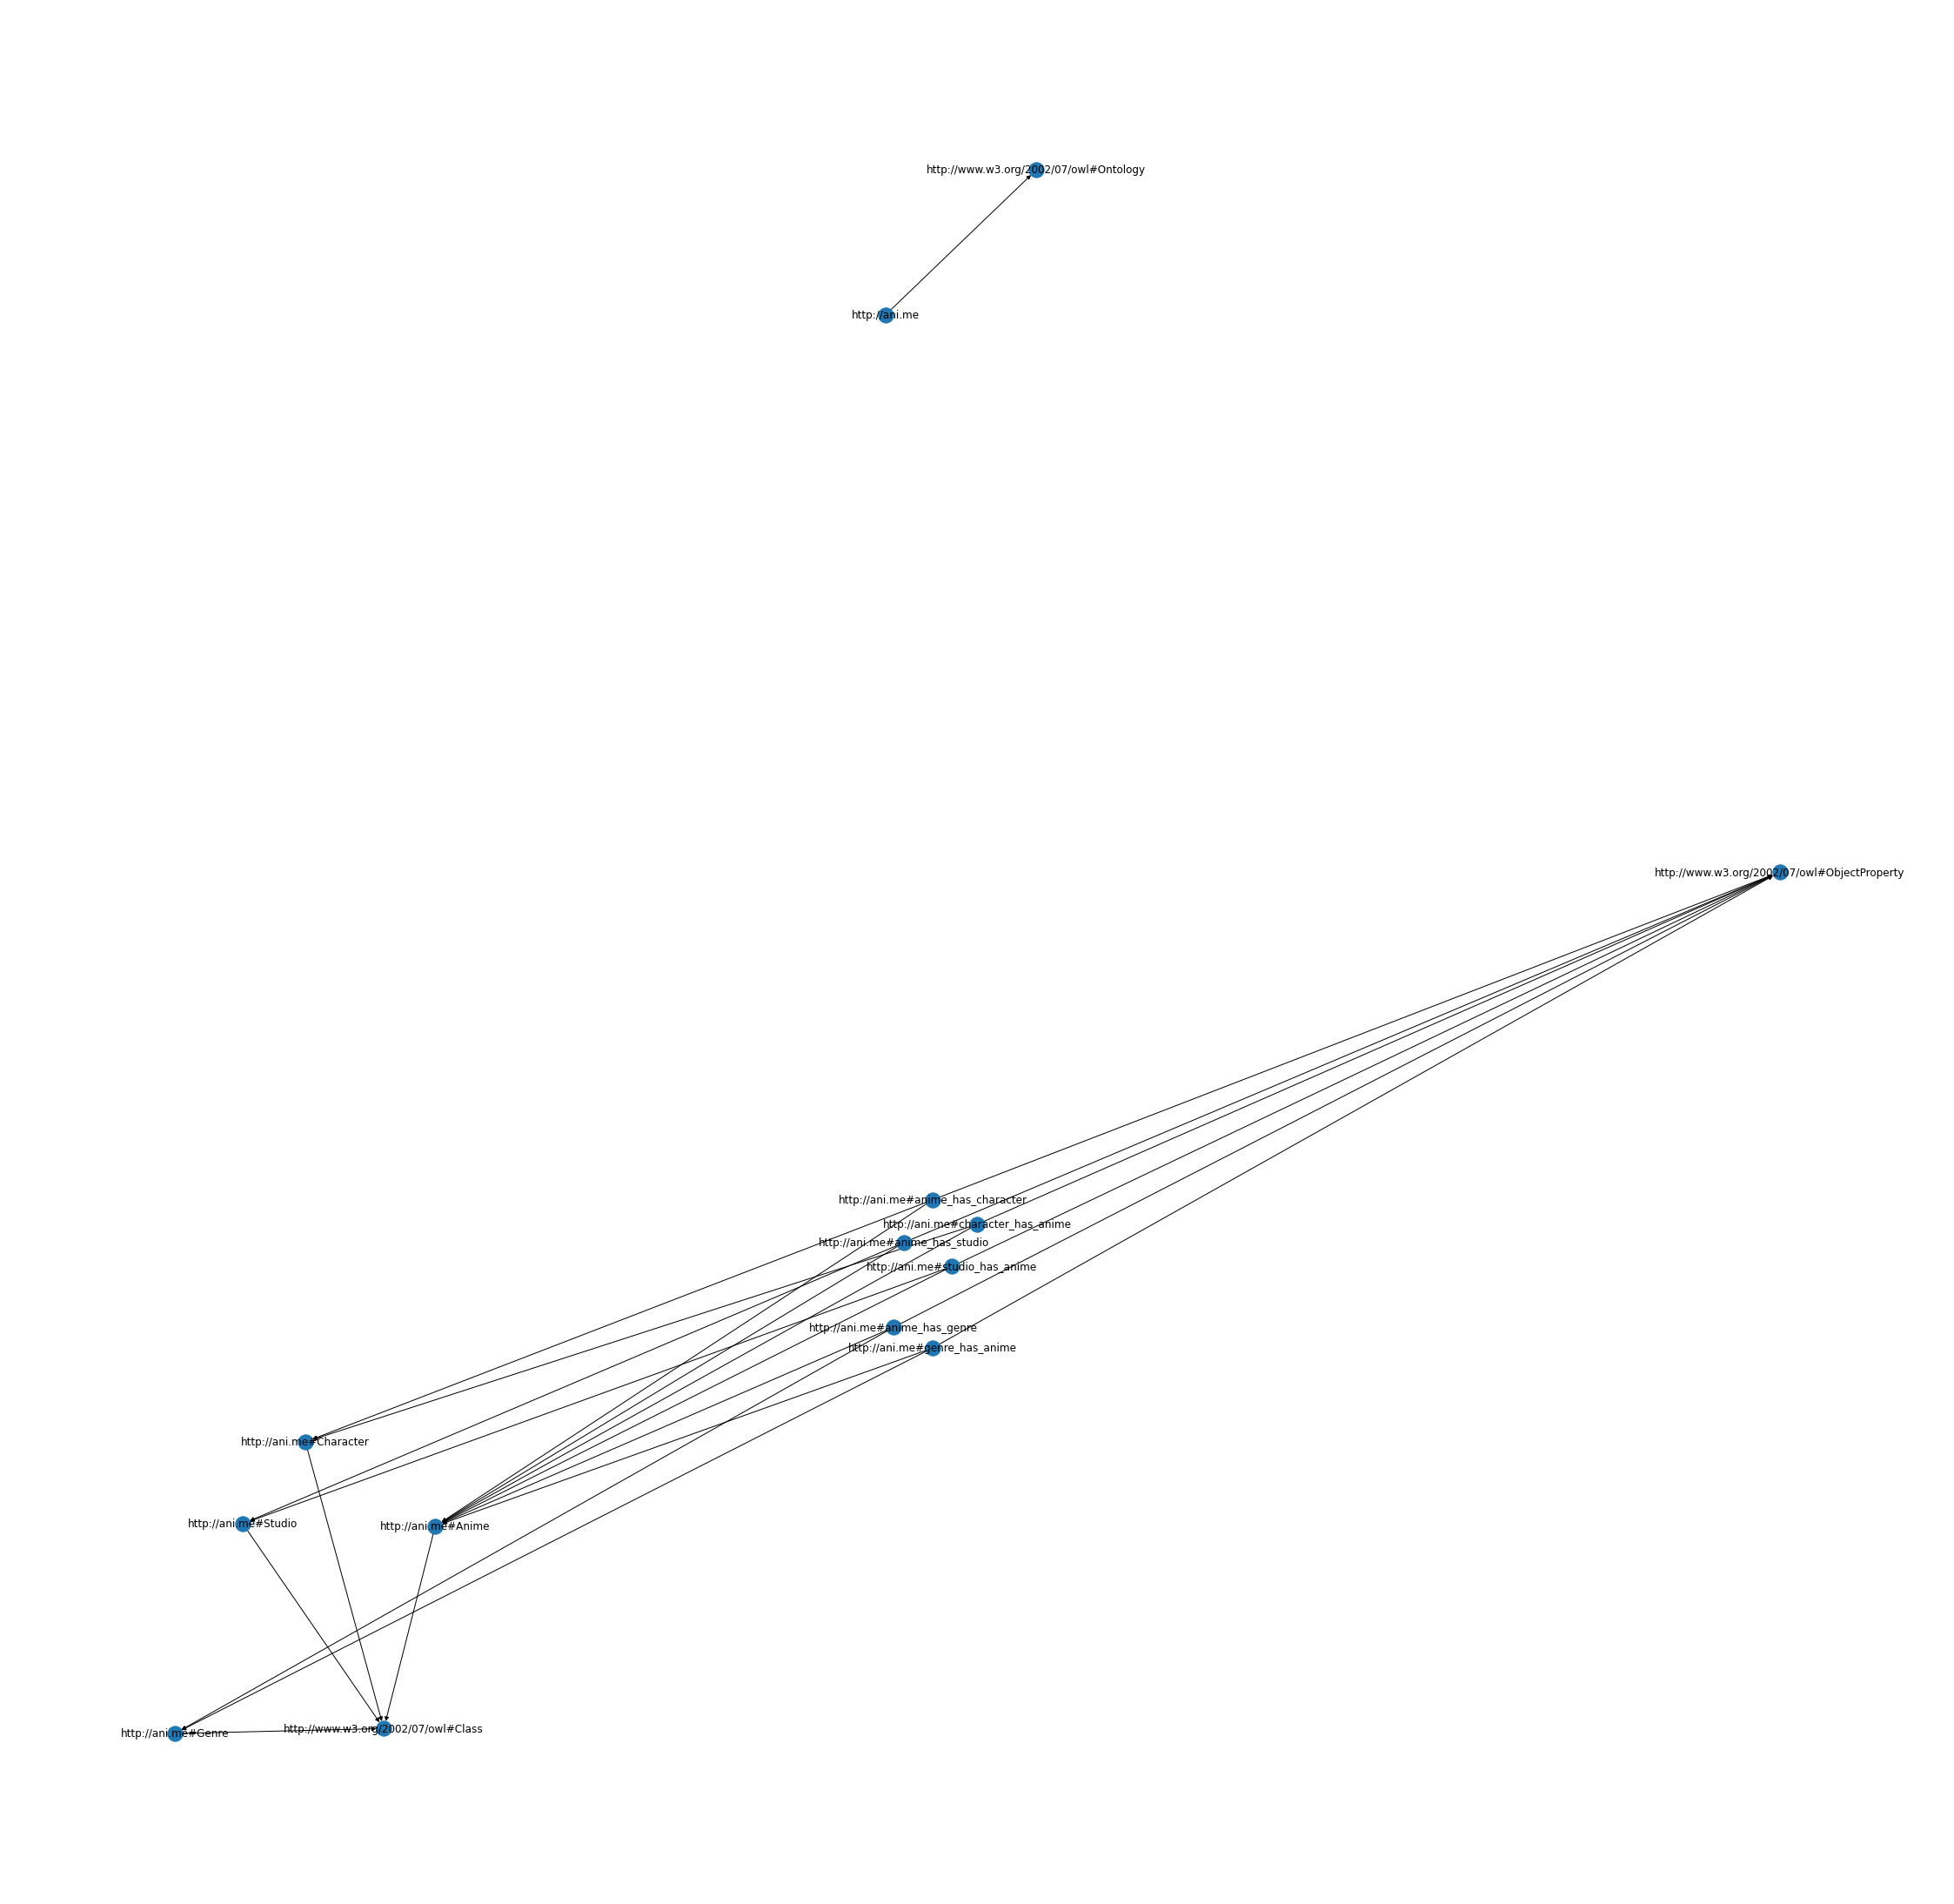

In [405]:
G = rdflib_to_networkx_multidigraph(result)
plt.rcParams['figure.figsize'] = [40, 40] # for square canvas
# Plot Networkx instance of RDF Graph
pos = nx.spring_layout(G, scale=1)
edge_labels = nx.get_edge_attributes(G, 'r')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
nx.draw(G, with_labels=True)

#if not in interactive mode for 
plt.show()

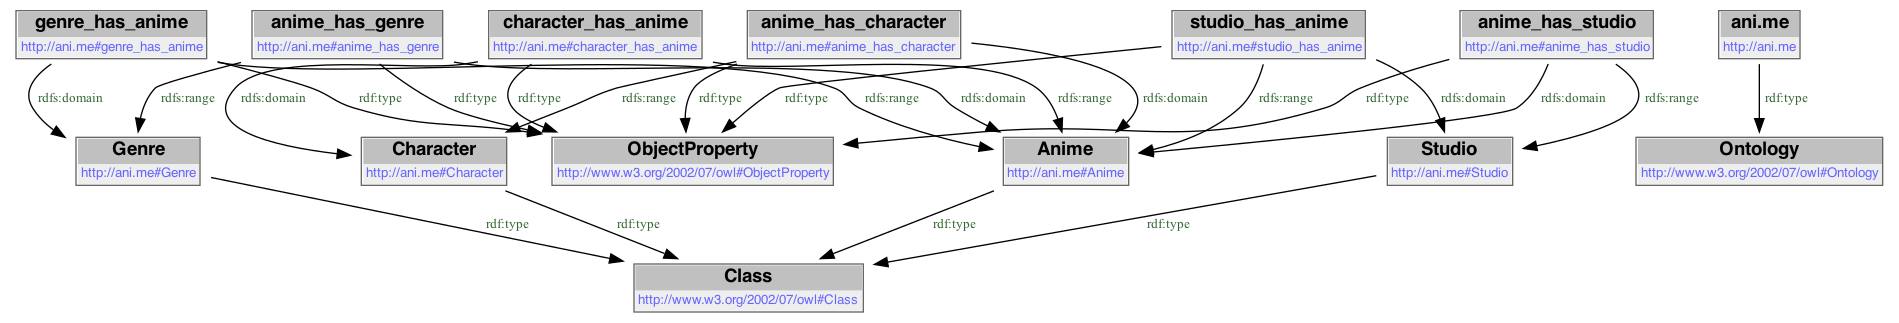

In [406]:
import io
import pydotplus
from IPython.display import display, Image
from rdflib.tools.rdf2dot import rdf2dot

def visualize(g):
    stream = io.StringIO()
    rdf2dot(g, stream, opts = {display})
    dg = pydotplus.graph_from_dot_data(stream.getvalue())
    png = dg.create_png()
    display(Image(png))

visualize(g)

In [407]:
g.serialize(destination="test.owl", format="n3")

<Graph identifier=Nf04aba821ba646b39f68b97d76aeb2d4 (<class 'rdflib.graph.Graph'>)>